In [1]:
import sys, os, warnings
from argparse import Namespace
warnings.filterwarnings("ignore")

import torch as ch
from torchvision import transforms
import numpy as np
from PIL import Image
from tqdm import tqdm
import torchvision

from helpers import classifier_helpers
import helpers.data_helpers as dh
import helpers.context_helpers as coh
import helpers.rewrite_helpers as rh
import helpers.vis_helpers as vh

import matplotlib.pyplot as plt
import random

import helpers.new_testing as nt
from helpers.new_testing import IMAGENET_CLASSES
from helpers.waterbirds import Waterbirds

%matplotlib inline

In [2]:
from omegaconf import OmegaConf

from helpers.waterbirds import Waterbirds, WaterbirdsEditing, WaterbirdsOrig, WaterbirdsBoring, WaterbirdsSimple

# overrides = OmegaConf.from_cli(flags.overrides)
cfg       = OmegaConf.load('configs/waterbirds.yaml')
base_cfg  = OmegaConf.load('configs/base.yaml')
args      = OmegaConf.merge(base_cfg, cfg)

# # dataset = Waterbirds('/shared/lisabdunlap/vl-attention/data', args)
# transform = transforms.Compose([
#             transforms.Resize((224,224)),
#             transforms.ToTensor(),
#             # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         ])

# dataset = WaterbirdsEditing('/shared/lisabdunlap/vl-attention/data', args, transform=transform)
# waterbirds = {'imgs': [], 'masks':[], 'labels':[]}
# # trans1 = transforms.ToTensor()
# for i in range(len(dataset)):
#     waterbirds['imgs'].append(dataset[i]['img'])
#     # invert mask
#     mask_copy = np.ones(dataset[i]['mask'].shape)
#     waterbirds['masks'].append(np.logical_xor(mask_copy, dataset[i]['mask']))
#     waterbirds['labels'].append(dataset[i]['label'])
# data = {}
# data['imgs'] = ch.stack(waterbirds['imgs'])
# data['masks'] = ch.stack(waterbirds['masks'])
# data['labels'] = ch.stack(waterbirds['labels'])
# ch.save(data, 'data/waterbirds/data.pt')

WATERBIRDS DIR: /shared/lisabdunlap/vl-attention/data/waterbird_1.0_forest2water2
NUMBER OF SAMPLES WITH LABEL Landbird: 3694
NUMBER OF SAMPLES WITH LABEL Waterbird: 1101
NUMBER OF SAMPLES WITH GROUP Land_on_Land: 3694
NUMBER OF SAMPLES WITH GROUP Land_on_Water: 0
NUMBER OF SAMPLES WITH GROUP Water_on_Land: 0
NUMBER OF SAMPLES WITH GROUP Water_on_Water: 1101


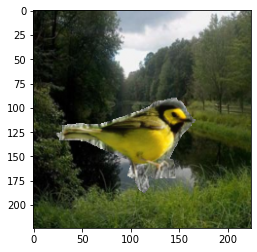

In [3]:
transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
dataset = WaterbirdsSimple('/shared/lisabdunlap/vl-attention/data', args, transform=transform)
plt.imshow(nt.get_displ_img(dataset[4002][0]))

In [5]:
# dataset = Waterbirds('/shared/lisabdunlap/vl-attention/data', args)
# transform = transforms.Compose([
#             transforms.Resize((224,224)),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         ])

# dataset = Waterbirds('/shared/lisabdunlap/vl-attention/data', args, split='test', transform=transform)
# data = {0.0:[], 1.0:[]}

# for i in range(len(dataset)):
#     if i % 100 == 0:
#         print(i)
#     data[dataset[i][1].item()].append(dataset[i][0])
# print(data)
# data2 = {}
# data2[0] = ch.stack(data[0])
# data2[1] = ch.stack(data[1])
# ch.save(data, 'data/waterbirds/data_test_normalized.pt')

In [4]:
DATASET_NAME = 'WaterbirdsSimple'
LAYERNUM = 12
REWRITE_MODE = 'editing'
ARCH = 'resnet50'
MODEL_PATH = '/home/lisabdunlap/EditingClassifiers/checkpoint/WaterbirdsSimple.pth'

## Load model

In [5]:
ret = classifier_helpers.get_default_paths(DATASET_NAME, arch=ARCH)
DATASET_PATH, MODEL_PATH, MODEL_CLASS, ARCH, CD = ret
print(MODEL_PATH)
ret = classifier_helpers.load_classifier(MODEL_PATH, MODEL_CLASS, ARCH,
                            DATASET_NAME, LAYERNUM)
model, context_model, target_model = ret[:3]
model

./checkpoint/WaterbirdsSimple.pth


ResNet(
  (layer0): InitBlock(
    (normalize): InputNormalize()
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): SeqBottleneck(
    (twin): Twin()
    (conv1): Wrapper(
      (module): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (bn1): Wrapper(
      (module): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu1): Wrapper(
      (module): ReLU()
    )
    (conv2): Wrapper(
      (module): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn2): Wrapper(
      (module): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu2): Wrapper(
      (module): ReLU()
    )
    (fina

## Load Waterbirds dataset and editing subset

In [6]:
base_dataset, train_loader, val_loader = dh.get_dataset(DATASET_NAME, '/shared/group/ilsvrc',
                                                        batch_size=32, workers=8)

WATERBIRDS DIR: /shared/lisabdunlap/vl-attention/data/waterbird_1.0_forest2water2
NUMBER OF SAMPLES WITH LABEL Landbird: 3694
NUMBER OF SAMPLES WITH LABEL Waterbird: 1101
NUMBER OF SAMPLES WITH GROUP Land_on_Land: 3694
NUMBER OF SAMPLES WITH GROUP Land_on_Water: 0
NUMBER OF SAMPLES WITH GROUP Water_on_Land: 0
NUMBER OF SAMPLES WITH GROUP Water_on_Water: 1101
WATERBIRDS DIR: /shared/lisabdunlap/vl-attention/data/waterbird_1.0_forest2water2
NUMBER OF SAMPLES WITH LABEL Landbird: 921
NUMBER OF SAMPLES WITH LABEL Waterbird: 278
NUMBER OF SAMPLES WITH GROUP Land_on_Land: 461
NUMBER OF SAMPLES WITH GROUP Land_on_Water: 460
NUMBER OF SAMPLES WITH GROUP Water_on_Land: 139
NUMBER OF SAMPLES WITH GROUP Water_on_Water: 139


In [7]:
# train_data, test_data = dh.get_waterbirds_data()
train_data, test_data = dh.get_waterbirds_simple_data()
test_data[0][0]

WATERBIRDS DIR: /shared/lisabdunlap/vl-attention/data/waterbird_1.0_forest2water2
NUMBER OF SAMPLES WITH LABEL Landbird: 3694
NUMBER OF SAMPLES WITH LABEL Waterbird: 1101
NUMBER OF SAMPLES WITH GROUP Land_on_Land: 3694
NUMBER OF SAMPLES WITH GROUP Land_on_Water: 0
NUMBER OF SAMPLES WITH GROUP Water_on_Land: 0
NUMBER OF SAMPLES WITH GROUP Water_on_Water: 1101
WATERBIRDS DIR: /shared/lisabdunlap/vl-attention/data/waterbird_1.0_forest2water2
NUMBER OF SAMPLES WITH LABEL Landbird: 4510
NUMBER OF SAMPLES WITH LABEL Waterbird: 1284
NUMBER OF SAMPLES WITH GROUP Land_on_Land: 2255
NUMBER OF SAMPLES WITH GROUP Land_on_Water: 2255
NUMBER OF SAMPLES WITH GROUP Water_on_Land: 642
NUMBER OF SAMPLES WITH GROUP Water_on_Water: 642


tensor([[[-1.6898, -1.8097, -1.8097,  ...,  0.0569, -0.1314,  0.3994],
         [-1.8268, -1.8268, -1.8268,  ..., -0.4397, -0.2856, -0.5424],
         [-1.8953, -1.8268, -1.7069,  ..., -0.7137, -0.2513, -0.3712],
         ...,
         [-1.4158, -1.6555, -1.7412,  ..., -0.9363, -1.1075, -0.9020],
         [-1.1932, -1.3302, -1.3815,  ..., -0.9363, -1.1075, -1.2103],
         [-1.6042, -1.7583, -1.4843,  ..., -0.9705, -0.9192, -1.5357]],

        [[-1.5805, -1.7031, -1.7031,  ...,  0.4328,  0.2402,  0.7829],
         [-1.7206, -1.7206, -1.7206,  ..., -0.0924,  0.0476, -0.1975],
         [-1.7906, -1.7206, -1.5980,  ..., -0.4076,  0.0826, -0.0399],
         ...,
         [-1.0903, -1.3354, -1.4055,  ..., -0.5651, -0.7402, -0.5126],
         [-0.8452, -1.0028, -1.0378,  ..., -0.5476, -0.7052, -0.8102],
         [-1.2654, -1.4230, -1.1604,  ..., -0.5651, -0.5126, -1.1429]],

        [[-1.4384, -1.5604, -1.5604,  ...,  0.4265,  0.2348,  0.7751],
         [-1.5779, -1.5779, -1.5779,  ..., -0

In [8]:
train_data.keys()

dict_keys(['imgs', 'modified_imgs', 'masks', 'labels'])

Train exemplars


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

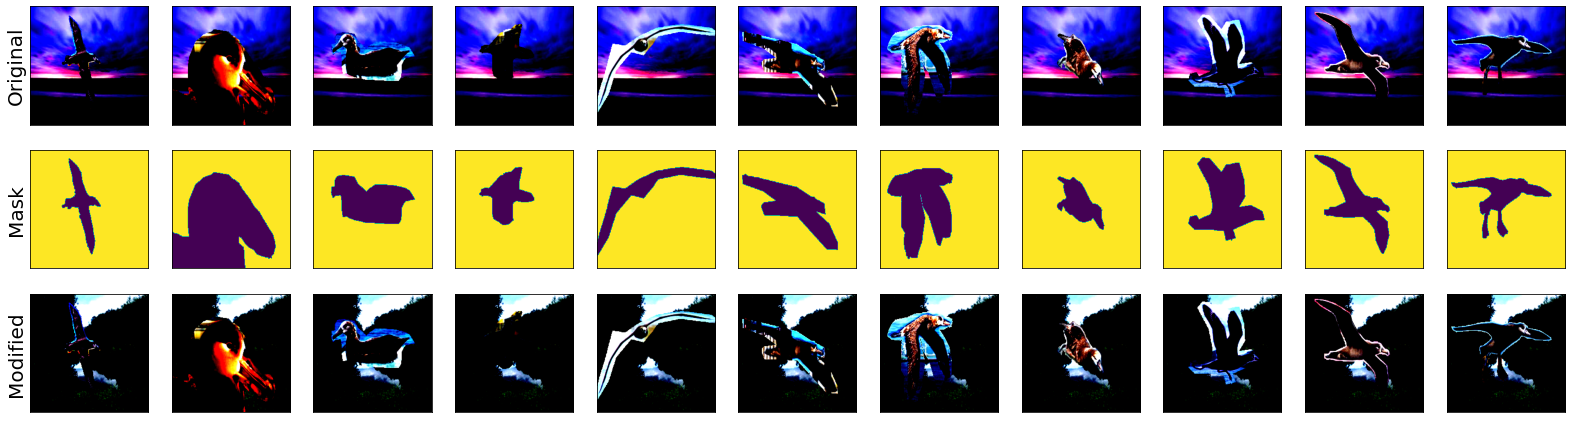

In [9]:
print("Train exemplars")
vh.show_image_row([train_data['imgs'], train_data['masks'], train_data['modified_imgs']], 
                  ['Original', 'Mask', 'Modified'], fontsize=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Balanced test set


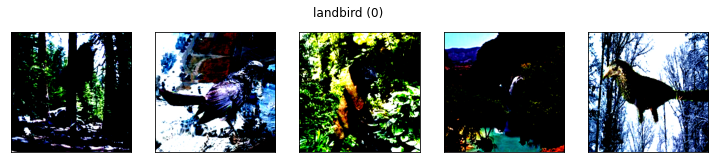

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


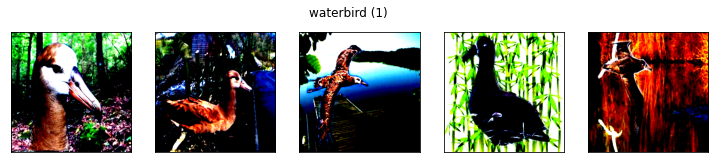

In [10]:
print("Balanced test set")
for c, x in test_data.items():
    vh.show_image_row([x[:5]], title=f'{CD[c]} ({c})')

## Evaluate model performance on test set pre-rewriting

In [11]:
print("Original accuracy on test Waterbirds data")

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        

RESULTS = {k: {'preds': {}, 'acc': {}} for k in ['pre', 'post']}
GLOBAL_RESULTS = {k: {'preds': {}, 'acc': {}} for k in ['pre', 'post']}
sub_batch = 32
for c, x in test_data.items():
    generator = chunks(x, sub_batch)
    correct = []
    for b in generator:
        with ch.no_grad():
            pred = model(b.cuda()).argmax(axis=1)
        correct += [p for p in pred if p == c]
    acc = 100 * len(correct) / len(x)
    print(f'Class: {c}/{CD[c]} | Accuracy: {acc:.2f}',) 
    RESULTS['pre']['acc'][c] = acc
    RESULTS['pre']['preds'][c] = pred

Original accuracy on test Waterbirds data
Class: 0/landbird | Accuracy: 76.03
Class: 1/waterbird | Accuracy: 51.40


In [ ]:
# correct, total = 0,0
# for i, (inputs, label) in enumerate(val_loader):
#     inputs, targets = inputs.cuda(), label.cuda()
#     with ch.no_grad():
#         predicted = model(inputs).argmax(axis=1)
#         total += targets.size(0)
#         correct += predicted.eq(targets).sum().item()
# print(correct/total)

In [14]:
ch.load('./checkpoints/waterbirds.pth')['acc']

73.31109257714762

## Perform re-write

In [15]:
train_args = {'ntrain': 1, # Number of exemplars
            'arch': ARCH, # Network architecture
            'mode_rewrite': REWRITE_MODE, # Rewriting method ['editing', 'finetune_local', 'finetune_global']
            'layernum': LAYERNUM, # Layer to modify
            'nsteps': 20000 if REWRITE_MODE == 'editing' else 400, # Number of rewriting steps  
            'lr': 1e-4, # Learning rate
            'restrict_rank': True, # Whether or not to perform low-rank update
            'nsteps_proj': 10, # Frequency of weight projection
            'rank': 1, # Rank of subspace to project weights
            'use_mask': True # Whether or not to use mask
             }
train_args = Namespace(**train_args)

In [16]:
context_model = rh.edit_classifier(train_args, 
                                   train_data, 
                                   context_model, 
                                   target_model=target_model, 
                                   val_loader=train_loader)

Computing cov matrices...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [14:58<00:00,  5.99s/it]
tensor(0.0486, device='cuda:0', grad_fn=<DivBackward0>): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:21<00:00, 930.43it/s]

Loss (orig, final): 0.054914239794015884 0.04863676801323891
L2 norm of weight change: 7.444836139678955


## Evaluate model performance on test set post-rewriting

In [17]:
print("Change in accuracy on test waterbirds data \n")

for c, x in test_data.items():
    generator = chunks(x, sub_batch)
    correct = []
    for b in generator:
        with ch.no_grad():
            pred = model(b.cuda()).argmax(axis=1)
        correct += [p for p in pred if p == c]
    acc = 100 * len(correct) / len(x)
    print(f'Class: {c}/{CD[c]} \n Accuracy change: {RESULTS["pre"]["acc"][c]:.2f} -> {acc:.2f} \n',) 
    RESULTS['post']['acc'][c] = acc
    RESULTS['post']['preds'][c] = pred

Change in accuracy on test waterbirds data 

Class: 0/landbird 
 Accuracy change: 76.03 -> 0.64 

Class: 1/waterbird 
 Accuracy change: 51.40 -> 0.16 

